## **Twitter Sentiment Analysis using NLP**
### DL Assignment-1 Q2


### **Import Libraries/Dataset**

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix

# nltk used as alternate apporach (Approch no: 2)
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import string

from tensorflow.keras.layers import Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from tensorflow.python.client import device_lib

import nltk
from nltk.corpus import stopwords
from nltk.corpus import stopwords 

# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### **Data Loading and Visualization**



Checking the GPU availability 

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

Listing devices

In [ ]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15187972336691912781, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14509932544
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9277527578401452127
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

#### Loading data

In [3]:
link = 'https://drive.google.com/file/d/1ywy-BPzBY2MbbykMumYG6a3xbuuwUQop/view?usp=sharing' # The shareable link
id = '1ywy-BPzBY2MbbykMumYG6a3xbuuwUQop'

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('training.1600000.processed.noemoticon.csv')  
data = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding = "ISO-8859-1")
data.columns = ["sentiment","ids","date","query_string","user","text"]

Printing five top records

In [4]:
data.head()

,sentiment,ids,date,query_string,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


Features in data 

In [5]:
data.columns 

Index(['sentiment', 'ids', 'date', 'query_string', 'user', 'text'], dtype='object')

 Shape of data

In [6]:
data.shape

(1599999, 6)

Print at least two movie reviews from each class of the dataset, for a sanity check that labels match the text.

polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

0 = Negative 

In [7]:
negative_review = data[data['sentiment']==0]
negative_review.head()

,sentiment,ids,date,query_string,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [8]:
negative_review.shape

(799999, 6)

 polarity of the tweet : 4 = positive



In [9]:
positive_review = data[data['sentiment']==4]
positive_review.head()

,sentiment,ids,date,query_string,user,text
799999,4,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!
800000,4,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting up with one of my besties tonight! ...
800001,4,1467822283,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,Wingman29,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800002,4,1467822287,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,katarinka,Being sick can be really cheap when it hurts t...
800003,4,1467822293,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,_EmilyYoung,@LovesBrooklyn2 he has that effect on everyone


In [10]:
positive_review.shape

(800000, 6)

polarity of the tweet: 2 = neutral

In [11]:
neutral_review = data[data['sentiment']==2]
neutral_review.head()

,sentiment,ids,date,query_string,user,text


In [12]:
neutral_review.shape

(0, 6)

Data information 

In [13]:
data.info()
type(data.text)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   sentiment     1599999 non-null  int64 
 1   ids           1599999 non-null  int64 
 2   date          1599999 non-null  object
 3   query_string  1599999 non-null  object
 4   user          1599999 non-null  object
 5   text          1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


pandas.core.series.Series

Plot a bar graph of class distribution in a dataset. Each bar depicts the number of tweets belonging to a particular sentiment

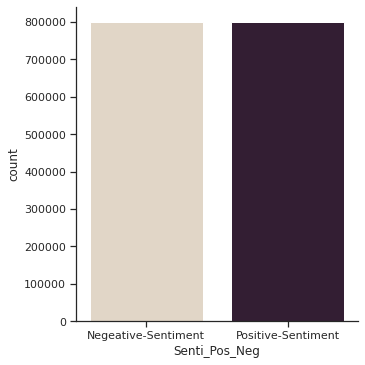

In [14]:

# create a list of our conditions
conditions = [
    (data['sentiment'] == 0),
    (data['sentiment'] == 4 ) 
    ]

# create a list of the values we want to assign for each condition
values = ['Negeative-Sentiment', 'Positive-Sentiment']

# create a new column and use np.select to assign values to it using our lists as arguments
data['Senti_Pos_Neg'] = np.select(conditions, values)
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)
# Categorical scatterplots
sns.catplot(x="Senti_Pos_Neg", kind="count", palette="ch:.25", data=data)

### **Data Pre-processing**

In [15]:
np.sum(data.isnull().any(axis=1))

0

In [16]:
print('Count of columns in the data is :',len(data.columns))

Count of columns in the data is : 7


In [17]:
print('Count of rows in the data is ',len(data))

Count of rows in the data is  1599999


In [18]:
# select only tweets and sentiment.
data=data[['text','sentiment']]

#  Assigning 1 to positive sentiment 4
data['sentiment'][data['sentiment']==4] = 1

# Separating positive and negative tweets.
data_pos = data[data['sentiment']==1]
data_neg = data[data['sentiment']==0]

#Taking one forth data so we can run on our machine easily.
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

#Taking half of the data so we can run on our machine easily.
#data_pos = data_pos.iloc[:int(40000)]
#data_neg = data_neg.iloc[:int(40000)]

#Combining positive and negative tweets.
data = pd.concat([data_pos, data_neg])

#Making all tweets to lowercase.
data['text']=data['text'].str.lower()

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 799999 to 19999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       40000 non-null  object
 1   sentiment  40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 937.5+ KB


In [20]:
data.head()

,text,sentiment
799999,i love @health4uandpets u guys r the best!!,1
800000,im meeting up with one of my besties tonight! ...,1
800001,"@darealsunisakim thanks for the twitter add, s...",1
800002,being sick can be really cheap when it hurts t...,1
800003,@lovesbrooklyn2 he has that effect on everyone,1


We used two approaches here to bring the train and test data in the required format

Approach1 - converting sentences to vectors using pre-trained embedding layer from TensorFlow hub (as mentioned in the assigment question)


In [21]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/nnlm-en-dim128/2")
embeddings = embed(data['text'])
embeddings


<tf.Tensor: shape=(40000, 128), dtype=float32, numpy=
array([[ 0.13271803,  0.06552115, -0.05014289, ..., -0.06968707,
         0.01226009, -0.11469741],
       [ 0.27051812,  0.06388213,  0.03982128, ...,  0.12367085,
         0.13651255,  0.00140675],
       [ 0.46855348,  0.05110646,  0.15010251, ...,  0.04474387,
         0.09825298, -0.11151113],
       ...,
       [ 0.41428247,  0.07766938,  0.04065007, ..., -0.06441787,
         0.14087844, -0.01980409],
       [ 0.58853245,  0.01427247,  0.18032347, ..., -0.07106814,
        -0.03796418, -0.03816634],
       [ 0.48951778, -0.00131879,  0.21947195, ..., -0.20358494,
         0.07959084,  0.03303012]], dtype=float32)>

Approach2 -  converting sentences to vectors using nltk.

and also cleaning the data.

In [22]:
#Cleaning and removing stop words of english.
nltk.download('stopwords')
stopwords_list = stopwords.words('english')

from nltk.corpus import stopwords 
",".join(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


"i,me,my,myself,we,our,ours,ourselves,you,you're,you've,you'll,you'd,your,yours,yourself,yourselves,he,him,his,himself,she,she's,her,hers,herself,it,it's,its,itself,they,them,their,theirs,themselves,what,which,who,whom,this,that,that'll,these,those,am,is,are,was,were,be,been,being,have,has,had,having,do,does,did,doing,a,an,the,and,but,if,or,because,as,until,while,of,at,by,for,with,about,against,between,into,through,during,before,after,above,below,to,from,up,down,in,out,on,off,over,under,again,further,then,once,here,there,when,where,why,how,all,any,both,each,few,more,most,other,some,such,no,nor,not,only,own,same,so,than,too,very,s,t,can,will,just,don,don't,should,should've,now,d,ll,m,o,re,ve,y,ain,aren,aren't,couldn,couldn't,didn,didn't,doesn,doesn't,hadn,hadn't,hasn,hasn't,haven,haven't,isn,isn't,ma,mightn,mightn't,mustn,mustn't,needn,needn't,shan,shan't,shouldn,shouldn't,wasn,wasn't,weren,weren't,won,won't,wouldn,wouldn't"

In [23]:
#Cleaning and removing the above stop words list from the tweet text.
STOPWORDS = set(stopwords.words('english'))
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
data['text'] = data['text'].apply(lambda text: cleaning_stopwords(text))
data['text'].head()

799999                love @health4uandpets u guys r best!!
800000    im meeting one besties tonight! cant wait!! - ...
800001    @darealsunisakim thanks twitter add, sunisa! g...
800002    sick really cheap hurts much eat real food plu...
800003                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

In [24]:
#Cleaning and Removing punctuatotions 
eng_punc = string.punctuation
punctuation_list = eng_punc
def cleaning_punctuation(text):
  translator = str.maketrans('','',punctuation_list)
  return text.translate(translator)

In [25]:
data['text'] = data['text'].apply(lambda x: cleaning_punctuation(x))
data['text'].tail()

19995                                     one day holidays
19996                     feeling right  hate damn humprey
19997    geezi hv read whole book personality types emb...
19998     threw sign donnie bent get thingee made sad face
19999    heather2711 good thing find none ones like com...
Name: text, dtype: object

In [26]:
#Cleaning and removing repeating characters
def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+',r'\1',text)


In [27]:
data['text'] = data['text'].apply(lambda x: cleaning_repeating_char(x))
data['text'].tail()

19995                                     one day holidays
19996                       feling right hate damn humprey
19997    gezi hv read whole bok personality types embar...
19998       threw sign donie bent get thinge made sad face
19999    heather271 god thing find none ones like come ...
Name: text, dtype: object

In [28]:
# Cleaning and removing emails.
def cleaning_email(data):
    return re.sub('@[^\s]+',' ',data)
data['text']=data['text'].apply(lambda x:cleaning_email(x))
data['text'].tail()

19995                                     one day holidays
19996                       feling right hate damn humprey
19997    gezi hv read whole bok personality types embar...
19998       threw sign donie bent get thinge made sad face
19999    heather271 god thing find none ones like come ...
Name: text, dtype: object

In [29]:
#Cleaning and remvoing URLS's
def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)
data['text']=data['text'].apply(lambda x: cleaning_URLs(x))
data['text'].tail()

19995                                     one day holidays
19996                       feling right hate damn humprey
19997    gezi hv read whole bok personality types embar...
19998       threw sign donie bent get thinge made sad face
19999    heather271 god thing find none ones like come ...
Name: text, dtype: object

In [30]:
#Cleaning and removing Numeric numbers
def cleaning_numbers(data):
    return re.sub('[0-9]+', '',data)
data['text']=data['text'].apply(lambda x: cleaning_numbers(x))
data['text'].tail()

19995                                     one day holidays
19996                       feling right hate damn humprey
19997    gezi hv read whole bok personality types embar...
19998       threw sign donie bent get thinge made sad face
19999    heather god thing find none ones like come siz...
Name: text, dtype: object

In [31]:
#Getting tokenization of tweet text
data_preproc1 = data
tokenizer = RegexpTokenizer(r'\w+')
data_preproc1['text']=data_preproc1['text'].apply(tokenizer.tokenize)
data_preproc1['text'].head()

799999             [love, healthuandpets, u, guys, r, best]
800000    [im, meting, one, besties, tonight, cant, wait...
800001    [darealsunisakim, thanks, twiter, ad, sunisa, ...
800002    [sick, realy, cheap, hurts, much, eat, real, f...
800003                      [lovesbroklyn, efect, everyone]
Name: text, dtype: object

In [32]:
#Applying Steamming
st = nltk.PorterStemmer()

def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return(data)

data_preproc1['text']=data_preproc1['text'].apply(lambda x: stemming_on_text(x))
data_preproc1['text'].head()

799999             [love, healthuandpets, u, guys, r, best]
800000    [im, meting, one, besties, tonight, cant, wait...
800001    [darealsunisakim, thanks, twiter, ad, sunisa, ...
800002    [sick, realy, cheap, hurts, much, eat, real, f...
800003                      [lovesbroklyn, efect, everyone]
Name: text, dtype: object

In [33]:
# Applying Lemmatizer 
import nltk
nltk.download('wordnet')

lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return(data)

data_preproc1['text']=data_preproc1['text'].apply(lambda x: lemmatizer_on_text(x))
data_preproc1['text'].head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


799999             [love, healthuandpets, u, guys, r, best]
800000    [im, meting, one, besties, tonight, cant, wait...
800001    [darealsunisakim, thanks, twiter, ad, sunisa, ...
800002    [sick, realy, cheap, hurts, much, eat, real, f...
800003                      [lovesbroklyn, efect, everyone]
Name: text, dtype: object

### **Model Building, Compilation and Training**

Approach1 - generated vectors using pre-trained embedding layer from TensorFlow hub



In [34]:
max_len = 500
sequences_matrix_1 = sequence.pad_sequences(embeddings,maxlen=max_len)

Approach2 - generated vectors using NLTK.

In [35]:
X=data.text
y=data.sentiment

max_len = 500
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

Separating the 70% data for training data and 30% for testing data
*   70% of tweets will be used in the training
*   30% of tweets will be used to test the performance of the model.


In [36]:
# Approach1
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix_1, y, test_size=0.3, random_state=2)

# Approach2
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(sequences_matrix, y, test_size=0.3, random_state=2)

Printing the shapes of train and test data ( as mentioned in the assigment question) 

In [37]:
X_train.shape

(28000, 500)

In [38]:
Y_train.shape

(28000,)

In [39]:
X_test.shape

(12000, 500)

In [40]:
Y_test.shape

(12000,)

In [41]:
X_train1.shape

(28000, 500)

In [42]:
Y_train1.shape

(28000,)

In [43]:
X_test1.shape

(12000, 500)

In [44]:
Y_test1.shape

(12000,)


**Model 1**
*  Sequential Model layers - 3 hidden layers with appropriate input for each.
*  Added L2 regularization to all the layers
*  Added activation function for all the layers
*  Selected appropriate activation function for all the layers.
*  Added one layer of dropout
*  Printed model summary

Hyperparamters tunning

*   batch_size=80 
*   Dropout: 0.2 at hidden layer1 (to prevent overfitting)
*   epochs=6
*   L2 regularization : 0.1
*   optimizer=RMSprop


Approach 2 : generated input data using NLTK.


Batch size =80 so the model takes 80 tweets in each iteration and train them.

Epochs = 6 so the model will train on the data 6 times

Epoch 1/6


312/315 [============================>.] - ETA: 0s - loss: 8.4266 - accuracy: 0.4985WARNING:tensorflow:Model was constructed with shape (None, 80, 500) for input KerasTensor(type_spec=TensorSpec(shape=(None, 80, 500), dtype=tf.float32, name='input_input'), name='input_input', description="created by layer 'input_input'"), but it was called on an input with incompatible shape (80, 500).


315/315 [==============================] - 5s 4ms/step - loss: 8.4225 - accuracy: 0.4983 - val_loss: 7.6080 - val_accuracy: 0.5093
Epoch 2/6
315/315 [==============================] - 1s 3ms/step - loss: 7.2348 - accuracy: 0.5021 - val_loss: 6.4142 - val_accuracy: 0.5057
Epoch 3/6
315/315 [==============================] - 1s 3ms/step - loss: 4.6334 - accuracy: 0.5031 - val_loss: 1.0225 - val_accuracy: 0.4954
Epoch 4/6
315/315 [==============================] - 1s 3ms/step - loss: 0.7644 - accuracy: 0.4993 - val_loss: 0.6988 - val_accuracy: 0.5132
Epoch 5/6
315/315 [==============================] - 1s 3ms/step - loss: 0.7052 - accuracy: 0.5011 - val_loss: 0.6972 - val_accuracy: 0.4946
Epoch 6/6
315/315 [==============================] - 1s 3ms/step - loss: 0.7003 - accuracy: 0.5061 - val_loss: 0.6964 - val_accuracy: 0.5139
Training finished !!
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              

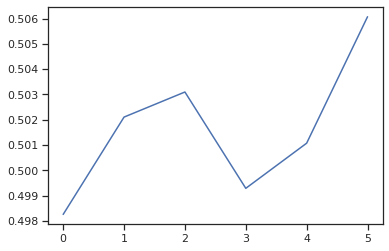

In [45]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define Sequential model with 3 layers
model1 = keras.Sequential(
    [
        layers.Dense(25, input_shape=(80, 500), name="input"),
        layers.Dense(250, kernel_regularizer=tf.keras.regularizers.L2(0.01), activation="relu", name="hidden_layer1"),
        layers.Dense(128, kernel_regularizer=tf.keras.regularizers.L2(0.01), activation="relu", name="hidden_layer2"),
        layers.Dense(64, kernel_regularizer=tf.keras.regularizers.L2(0.01), activation="relu", name="hidden_layer3"),
        layers.Dropout(0.2),
        layers.Dense(1, kernel_regularizer=tf.keras.regularizers.L2(0.01), name="output"),
    ]
)
model1.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
history=model1.fit(X_train1,Y_train1,batch_size=80,epochs=6, validation_split=0.1)# here we are starting the training of model by feeding the training data
print('Training finished !!')
model1.summary()

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])


**Model 2**
*  Sequential Model layers - 5 hidden layers with appropriate input for each.
*  Added L2 regularization to all the layers
*  Added activation function for all the layers
*  Selected appropriate activation function for all the layers.
*  Added one layer of dropout
*  Printed model summary

Hyperparamters tunning

*   batch_size=40 
*   Dropout: 0.2 at hidden layer2 (to prevent overfitting)
*   epochs=8
*   L2 regularization : 0.01
*   optimizer=adam

Approach 2 : generated input data using NLTK.

Epoch 1/8


630/630 [==============================] - ETA: 0s - loss: 9.2243 - accuracy: 0.4967WARNING:tensorflow:Model was constructed with shape (None, 40, 500) for input KerasTensor(type_spec=TensorSpec(shape=(None, 40, 500), dtype=tf.float32, name='input_input'), name='input_input', description="created by layer 'input_input'"), but it was called on an input with incompatible shape (40, 500).


630/630 [==============================] - 2s 3ms/step - loss: 9.2243 - accuracy: 0.4967 - val_loss: 8.8258 - val_accuracy: 0.4946
Epoch 2/8
630/630 [==============================] - 2s 3ms/step - loss: 8.4230 - accuracy: 0.5034 - val_loss: 8.2058 - val_accuracy: 0.5054
Epoch 3/8
630/630 [==============================] - 2s 3ms/step - loss: 6.6632 - accuracy: 0.5008 - val_loss: 1.5818 - val_accuracy: 0.4968
Epoch 4/8
630/630 [==============================] - 2s 3ms/step - loss: 1.2621 - accuracy: 0.5083 - val_loss: 1.1230 - val_accuracy: 0.5139
Epoch 5/8
630/630 [==============================] - 2s 3ms/step - loss: 1.0604 - accuracy: 0.5110 - val_loss: 1.0022 - val_accuracy: 0.5096
Epoch 6/8
630/630 [==============================] - 2s 3ms/step - loss: 0.9589 - accuracy: 0.5125 - val_loss: 0.9218 - val_accuracy: 0.4996
Epoch 7/8
630/630 [==============================] - 2s 3ms/step - loss: 0.8895 - accuracy: 0.5154 - val_loss: 0.8624 - val_accuracy: 0.5011
Epoch 8/8
630/630 [====

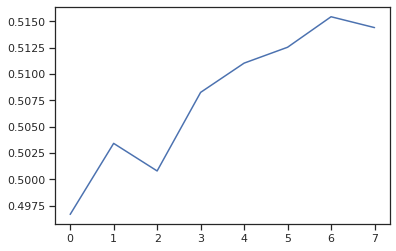

In [50]:
# Define Sequential model with 5 layers
model2 = keras.Sequential(
    [
        layers.Dense(30, input_shape=(40, 500), name="input"),
        layers.Dense(256, kernel_regularizer=tf.keras.regularizers.L2(0.01), activation="relu", name="hidden_layer1"),
        layers.Dense(124, kernel_regularizer=tf.keras.regularizers.L2(0.01), activation="relu", name="hidden_layer2"),
        layers.Dropout(0.2),
        layers.Dense(64, kernel_regularizer=tf.keras.regularizers.L2(0.01), activation="relu", name="hidden_layer3"),
        layers.Dense(32, kernel_regularizer=tf.keras.regularizers.L2(0.01), activation="relu", name="hidden_layer4"),
        layers.Dense(16, kernel_regularizer=tf.keras.regularizers.L2(0.01), activation="relu", name="hidden_layer5"),
        layers.Dense(1, kernel_regularizer=tf.keras.regularizers.L2(0.01), name="output"),
    ]
)
model2.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])
history=model2.fit(X_train1,Y_train1,batch_size=40,epochs=8, validation_split=0.1)# here we are starting the training of model by feeding the training data
print('Training finished !!')
model2.summary()

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])


**Model 3**
*  Sequential Model layers - 3 hidden layers with appropriate input for each.
*  Added L2 regularization to all the layers
*  Added activation function for all the layers
*  Selected appropriate activation function for all the layers.
*  Added one layer of dropout
*  Printed model summary

Hyperparamters tunning

*   batch_size=80 
*   Dropout: 0.1 at hidden layer1 (to prevent overfitting)
*   epochs=6
*   L2 regularization : 0.01
*   optimizer=RMSprop

Approach 1 : generated input data  using pre-trained embedding layer from TensorFlow hub.

Batch size =80 so the model takes 80 tweets in each iteration and train them.

Epochs = 6 so the model will train on the data 6 times

Epoch 1/6
315/315 [==============================] - 2s 4ms/step - loss: 1.1281 - accuracy: 0.4944 - val_loss: 0.6936 - val_accuracy: 0.4946
Epoch 2/6
315/315 [==============================] - 1s 3ms/step - loss: 0.6936 - accuracy: 0.4961 - val_loss: 0.6936 - val_accuracy: 0.5054
Epoch 3/6
315/315 [==============================] - 1s 3ms/step - loss: 0.6936 - accuracy: 0.4995 - val_loss: 0.6936 - val_accuracy: 0.5054
Epoch 4/6
315/315 [==============================] - 1s 3ms/step - loss: 0.6936 - accuracy: 0.4981 - val_loss: 0.6936 - val_accuracy: 0.5054
Epoch 5/6
315/315 [==============================] - 1s 3ms/step - loss: 0.6936 - accuracy: 0.4992 - val_loss: 0.6936 - val_accuracy: 0.4946
Epoch 6/6
315/315 [==============================] - 1s 3ms/step - loss: 0.6936 - accuracy: 0.5002 - val_loss: 0.6936 - val_accuracy: 0.4946
Training finished !!
Model: "3_hidden_layer_mlp"
_________________________________________________________________
Layer (type)                 Output Sha

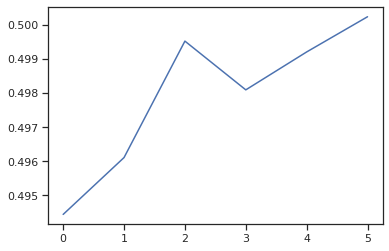

In [52]:
class ThreeLayerMLP(keras.Model):

  def __init__(self, name=None):
    super(ThreeLayerMLP, self).__init__(name=name)
    self.dense_1 = layers.Dense(30,kernel_regularizer=tf.keras.regularizers.L2(0.01),input_shape=(2000,50), name='input')
    self.dense_2 = layers.Dense(512, kernel_regularizer=tf.keras.regularizers.L2(0.01),activation='relu', name='hidden_layer1')
    layers.Dropout(0.1)
    self.dense_3 = layers.Dense(256, kernel_regularizer=tf.keras.regularizers.L2(0.01),activation='relu', name='hidden_layer2')
    self.dense_4 = layers.Dense(128, kernel_regularizer=tf.keras.regularizers.L2(0.01),activation='relu', name='hidden_layer3')
 
    self.pred_layer = layers.Dense(1,kernel_regularizer=tf.keras.regularizers.L2(0.01), activation='sigmoid',name='predictions')

  def call(self, inputs):
    x = self.dense_1(inputs)
    x = self.dense_2(x)
    x = self.dense_3(x)
    x = self.dense_4(x)
    return self.pred_layer(x)

def get_model():
  return ThreeLayerMLP(name='3_hidden_layer_mlp')

model3 = get_model()
model3.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
history=model3.fit(X_train,Y_train,batch_size=80,epochs=6, validation_split=0.1)# here we are starting the training of model by feeding the training data
print('Training finished !!')
model3.summary()

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])

**Model 4**
*  Sequential Model layers - 5 hidden layers with appropriate input for each.
*  Added L2 regularization.
*  Added activation function for all the layers
*  Selected appropriate activation function for all the layers.
*  Added  dropout layers
*  Printed model summary

Hyperparamters tunning

*   batch_size=40 
*   Dropout: 0.1 at hidden layer2 (to prevent overfitting)
*   epochs=8
*   L2 regularization : 0.01
*   optimizer=adam

Approach 2 : generated input data using NLTK.

Batch size = 40 so the model takes 40 tweets in each iteration and train them.

Epochs = 10 so the model will train on the data 10 times

Epoch 1/8
280/280 [==============================] - 1s 3ms/step - loss: 3.1484 - accuracy: 0.5091 - val_loss: 2.2037 - val_accuracy: 0.5286
Epoch 2/8
280/280 [==============================] - 1s 3ms/step - loss: 1.7886 - accuracy: 0.5162 - val_loss: 1.4699 - val_accuracy: 0.5179
Epoch 3/8
280/280 [==============================] - 1s 3ms/step - loss: 1.2781 - accuracy: 0.5127 - val_loss: 1.1223 - val_accuracy: 0.5154
Epoch 4/8
280/280 [==============================] - 1s 3ms/step - loss: 1.0222 - accuracy: 0.5194 - val_loss: 0.9399 - val_accuracy: 0.5204
Epoch 5/8
280/280 [==============================] - 1s 3ms/step - loss: 0.8855 - accuracy: 0.5175 - val_loss: 0.8401 - val_accuracy: 0.5204
Epoch 6/8
280/280 [==============================] - 1s 3ms/step - loss: 0.8097 - accuracy: 0.5108 - val_loss: 0.7838 - val_accuracy: 0.5204
Epoch 7/8
280/280 [==============================] - 1s 3ms/step - loss: 0.7664 - accuracy: 0.5148 - val_loss: 0.7516 - val_accuracy: 0.5125
Epoch 8/8
280

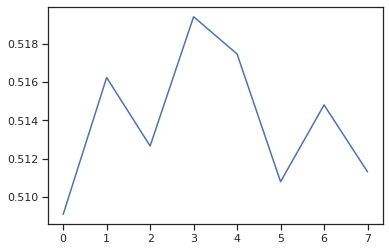

In [60]:
class FiveLayerMLP(keras.Model):

  def __init__(self, name=None):
    super(FiveLayerMLP, self).__init__(name=name)
    self.dense_1 = layers.Dense(20,input_shape=(2000,50), name='input')
    self.dense_2 = layers.Dense(256, kernel_regularizer=tf.keras.regularizers.L2(0.01),activation='relu', name='hidden_1')
    self.dense_3 = layers.Dense(128, kernel_regularizer=tf.keras.regularizers.L2(0.01),activation='relu', name='hidden_2')
    layers.Dropout(0.01)
    self.dense_4 = layers.Dense(64, kernel_regularizer=tf.keras.regularizers.L2(0.01),activation='relu', name='hidden_3')
    self.dense_5 = layers.Dense(32, kernel_regularizer=tf.keras.regularizers.L2(0.01),activation='relu', name='hidden_4')
    self.dense_6 = layers.Dense(16, kernel_regularizer=tf.keras.regularizers.L2(0.02),activation='relu', name='hidden_5')
    self.pred_layer = layers.Dense(1, activation='sigmoid',name='predictions')

  def call(self, inputs):
    x = self.dense_1(inputs)
    x = self.dense_2(x)
    x = self.dense_3(x)
    x = self.dense_4(x)
    x = self.dense_5(x)
    x = self.dense_6(x)
    return self.pred_layer(x)

def get_model4():
  return FiveLayerMLP(name='5_layer_mlp')

model4 = get_model4()
model4.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])
history=model4.fit(X_train1,Y_train1,batch_size=90,epochs=8, validation_split=0.1)# here we are starting the training of model by feeding the training data
print('Training finished !!')
model4.summary()

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])

**Model 5**
*  LSTM is used.
*  Added activation function for all the layers
*  Selected appropriate activation function for all the layers.
*  Added one layer of dropout
*  Printed model summary

Hyperparamters tunning

*   batch_size=80 
*   Dropout: 0.5 at hidden layer1 (to prevent overfitting)
*   epochs=6
*   optimizer=RMSprop

Approach 2 : generated input data using NLTK.


Epoch 1/6
315/315 [==============================] - 9s 25ms/step - loss: 0.5765 - accuracy: 0.6878 - val_loss: 0.5260 - val_accuracy: 0.7339
Epoch 2/6
315/315 [==============================] - 7s 24ms/step - loss: 0.4996 - accuracy: 0.7588 - val_loss: 0.5183 - val_accuracy: 0.7482
Epoch 3/6
315/315 [==============================] - 7s 23ms/step - loss: 0.4808 - accuracy: 0.7681 - val_loss: 0.5291 - val_accuracy: 0.7511
Epoch 4/6
315/315 [==============================] - 7s 23ms/step - loss: 0.4614 - accuracy: 0.7776 - val_loss: 0.5418 - val_accuracy: 0.7371
Epoch 5/6
315/315 [==============================] - 7s 23ms/step - loss: 0.4356 - accuracy: 0.7881 - val_loss: 0.5776 - val_accuracy: 0.7332
Epoch 6/6
315/315 [==============================] - 8s 24ms/step - loss: 0.4131 - accuracy: 0.7979 - val_loss: 0.6083 - val_accuracy: 0.7250
Training finished !!
Model: "3_layer_mlp"
_________________________________________________________________
Layer (type)                 Output Shap

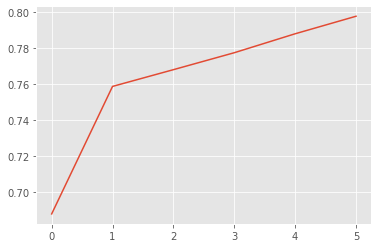

In [ ]:
from tensorflow.keras.layers import LSTM
def tensorflow_based_model(): #Defined tensorflow_based_model function for training tenforflow based model
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(2000,50,input_length=max_len)(inputs) 
    layer = LSTM(64)(layer) 
    layer = Dense(256,name='FC1')(layer) 
    layer = Activation('relu')(layer) 
    layer = Dropout(0.5)(layer) 
    layer = Dense(1,name='out_layer')(layer) #step4 again but this time its giving only one output as because we need to classify the tweet as positive or negative
    layer = Activation('sigmoid')(layer) #step5 but this time activation function is sigmoid for only one output.
    model = Model(inputs=inputs,outputs=layer) #here we are getting the final output value in the model for classification
    return model #function returning the value when we call it

model5 = tensorflow_based_model()
model5.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history=model5.fit(X_train1,Y_train1,batch_size=80,epochs=6, validation_split=0.1)# here we are starting the training of model by feeding the training data
print('Training finished !!')
model3.summary()

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])


### **Model Evaluation** 

**Model4**

In [61]:
accr1 = model4.evaluate(X_test1,Y_test1)

375/375 [==============================] - 1s 2ms/step - loss: 0.7322 - accuracy: 0.5128


In [62]:
print('Test set\n Accuracy:{:0.2f}'.format(accr1[1]))

Test set
 Accuracy:0.51


In [63]:
y_pred = model4.predict(X_test1) #getting predictions on the trained model
y_pred = (y_pred > 0.5)


 Confusion Matrix 

[[2523 3486]
 [2360 3631]]




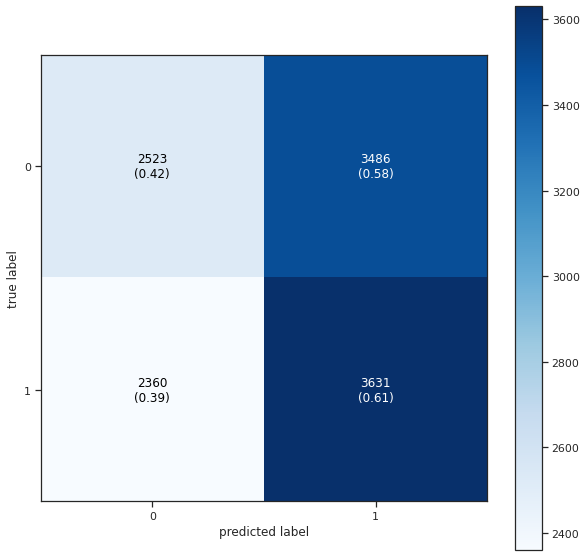

In [64]:
print('\n Confusion Matrix \n')
CR = confusion_matrix(Y_test,y_pred)
print(CR)
print('\n')

fig,ax = plot_confusion_matrix(conf_mat = CR,figsize = (10,10),
                              show_absolute = True,
                              show_normed = True,
                              colorbar = True)

**Model5**

In [ ]:
accr1 = model5.evaluate(X_test1,Y_test1)

375/375 [==============================] - 4s 9ms/step - loss: 0.5909 - accuracy: 0.7265


In [ ]:
print('Test set\n Accuracy:{:0.2f}'.format(accr1[1]))

Test set
 Accuracy:0.73


In [ ]:
y_pred = model5.predict(X_test1) #getting predictions on the trained model
y_pred = (y_pred > 0.5)


 Confusion Matrix 

[[4225 1784]
 [1498 4493]]




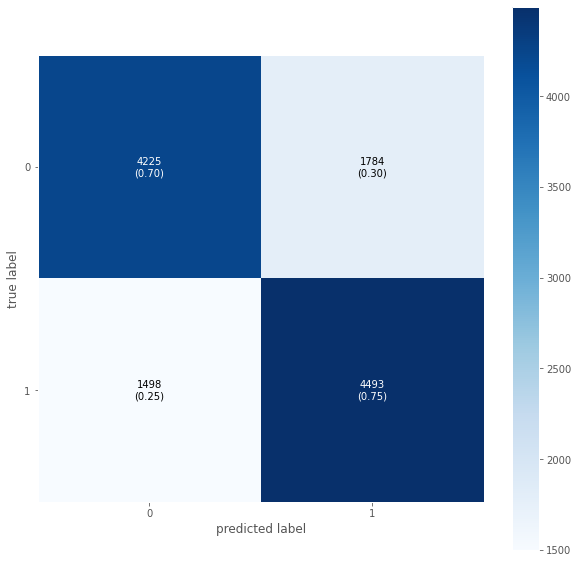

In [ ]:
print('\n Confusion Matrix \n')
CR = confusion_matrix(Y_test,y_pred)
print(CR)
print('\n')

fig,ax = plot_confusion_matrix(conf_mat = CR,figsize = (10,10),
                              show_absolute = True,
                              show_normed = True,
                              colorbar = True)